In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import itertools
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import sqlite3
import pandas as pd

In [5]:
# Create SQLite database connection
conn = sqlite3.connect("database.db")
cursor = conn.cursor()

# Select data from the table
query = "SELECT * FROM patient"
df = pd.read_sql_query(query, conn)

# Remove NaN values and update the original DataFrame (in-place)
df.dropna(inplace=True)

# Close the connection (optional - good practice)
conn.close()
# Now df should not contain NaN values


In [6]:
df=df[["PatientID", "Gender", "Age", "AgeCat", "Occupation", "Ethnicity", "Education", "Height", "Weight", "BMI", 
                    "BP_sytolic", "BP_Distolic", "BP_category", 
                    "Pusle_rate", "Temperature", "Diet_compliance", "Smoking_status", 
                    "Alcohol_consumption", "Physical_activity", 
                    "Consultation_fee"]]

# print(df)

In [27]:
# Assigned code number to represent body mass index 
def bmi_category(bmi):
  if bmi <= 18.5:
    return 0
  elif 18.5 < bmi <= 24.9:
    return 0
  elif 25.0 <= bmi < 30.0: 
    return 1
  else:
    return 1
# Add a new column 'BMI_code' with categories
df = df.assign(BMI_code=df['BMI'].apply(bmi_category))

In [29]:
# # Assigned code number to represent Blood pressure
def bp_category(bp):
  if bp == 'Normal':
    return 0
  elif bp == 'Elevated':
   return 0    
  elif bp == 'Stage 1 hypertension':  # Double equals for comparison
    return 1
  else:
    return 2  # Assuming 'Stage 2 hypertension' maps to 2

# Add a new column 'BP_code' with categories
df = df.assign(BP_code=df['BP_category'].apply(bp_category))

In [30]:
# Data Mapping/Preprocessing
gender_mapping = {"Male": 0, "Female": 1}
agecat_mapping = {"5-14yrs": 0, "15-24yrs": 1, "25-34yrs": 2, "35-44yrs": 3, "45-54yrs": 4, "55yers and above": 5}
occupation_mapping = {"Unemployed": 0, "Business": 1, "Farmer": 2, "Student": 3, "Civil servant": 4, "Tailor": 5, "Carpenter": 6, "Engineer": 7, "Others": 8}
education_mapping = {"Non-formal": 0, "Primary": 1, "Secondary": 1, "Tertiary": 3}
bp_mapping = {'Normal': 0, 'Elevated': 0, 'Stage 1 hypertension': 1, 'Stage 2 hypertension': 1}
diet_compliance_mapping = {"No": 0, "Yes": 1}
smoking_status_mapping = {"No": 0, "Yes": 1}
alcohol_consumption_mapping = {"No": 0, "Yes": 1}
physical_activity_mapping = {"No": 0, "Yes": 1}
df.loc[:,'BMI_code'] = df['BMI'].apply(bmi_category)

In [31]:
# Asigning code numbers to categorical varibales 
df.loc[:,"PatientID"] = df["PatientID"]
df.loc[:,"Gender_code"] = df["Gender"].map(gender_mapping)
df.loc[:,"AgeCat_code"] = df["AgeCat"].map(agecat_mapping)
df.loc[:,"Occupation_code"] = df["Occupation"].map(occupation_mapping)
df.loc[:,"Education_code"] = df["Education"].map(education_mapping)
df.loc[:,'BMI_code'] = df['BMI'].apply(bmi_category)
df.loc[:,"BP_code"] = df["BP_category"].map(bp_mapping)  # Assuming BP_category stores class labels
df.loc[:,"Diet_compliance_code"] = df["Diet_compliance"].map(diet_compliance_mapping)
df.loc[:,"Smoking_status_code"] = df["Smoking_status"].map(smoking_status_mapping)
df.loc[:,"Alcohol_consumption_code"] = df["Alcohol_consumption"].map(alcohol_consumption_mapping)
df.loc[:,"Physical_activity_code"] = df["Physical_activity"].map(physical_activity_mapping)

In [33]:
# Displayed the coded data 
feature_df=df[["PatientID","Gender_code", "AgeCat_code", "Occupation_code", 
          "Education_code", "Diet_compliance_code", "Smoking_status_code",
          "Alcohol_consumption_code", "Physical_activity_code"]]
feature_df=feature_df.dropna()
print(feature_df)

    PatientID  Gender_code  AgeCat_code  Occupation_code  Education_code  \
0       P0001            0            2                4               3   
1       P0002            1            1                3               1   
2       P0009            0            1                3               1   
3       P0007            1            1                3               1   
4       P0010            1            4                4               3   
..        ...          ...          ...              ...             ...   
299    P00026            0            2                4               3   
300    P00027            1            1                3               1   
301    P00028            0            1                3               1   
302    P00029            1            1                3               1   
303    P00030            1            4                4               3   

     Diet_compliance_code  Smoking_status_code  Alcohol_consumption_code  \
0          

In [34]:
# Preprocess the data
# Exclude 'Unnamed: 0' column
X = feature_df.drop(['PatientID'], axis=1)
X=np.asarray(X)
X[0:5]

array([[0, 2, 4, 3, 0, 1, 0, 0],
       [1, 1, 3, 1, 1, 0, 0, 1],
       [0, 1, 3, 1, 0, 0, 0, 1],
       [1, 1, 3, 1, 1, 0, 0, 0],
       [1, 4, 4, 3, 0, 0, 0, 1]])

In [35]:
# Class for Dibetic 
y_BMI = df['BMI_code'] = df['BMI_code'].astype('int')
y_BMI= np.asarray(df['BMI_code'])
y_BMI[0:5]

array([1, 0, 1, 0, 0])

In [36]:
# Class for  Hypertension
y_BP = df['BP_code'] = df['BP_code'].astype('int')
y_BP= np.asarray(df['BP_code'])
y_BP[0:5]

array([1, 0, 0, 0, 1])

In [39]:
# # Train and test split for Dibetic
# X_train, X_test, y_train, y_test = train_test_split(X, y_BMI, test_size=0.30, random_state=21)
# print ('Train set:', X_train.shape,  y_train.shape)
# print ('Test set:', X_test.shape,  y_test.shape)

In [40]:
# Train and test split for hypertension
X_train, X_test, y_train, y_test = train_test_split(X, y_BP, test_size=0.40, random_state=21)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (182, 8) (182,)
Test set: (122, 8) (122,)


In [41]:
# Train the models
from sklearn.svm import SVC  # Import SVC from sklearn.svm

models = {
  'Logistic Regression': LogisticRegression(),
  'Support Vector Machine': SVC(kernel='rbf', gamma='auto'),  # Define SVM within the loop
  'Decision Tree': DecisionTreeClassifier(),
  'Random Forest': RandomForestClassifier(),
  'Gradient Boosting': GradientBoostingClassifier()
}


In [43]:
for name, model in models.items():
  model.fit(X_train, y_train)  # Train each model in the dictionary

clf =SVC(kernel='rbf')
print(clf.fit(X_train, y_train))

SVC()


In [44]:
yhat = clf.predict(X_test)
yhat [0:5]

array([0, 0, 0, 0, 0])

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [46]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        32

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122

Confusion matrix, without normalization
[[90  0]
 [ 0 32]]


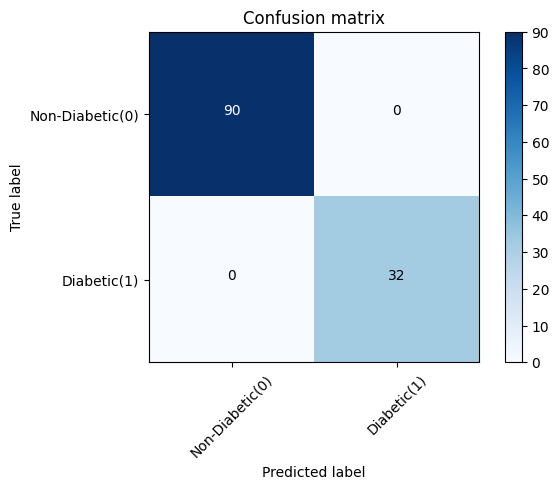

In [47]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non-Diabetic(0)','Diabetic(1)'],normalize= False,  title='Confusion matrix')